# `setriq`: Example usage

`setriq` allows us to quickly compute distances between strings. Here we analyse a small example dataset of T-cell receptor (TCR) CDR3 $\beta$ sequences, which is a special type of biological sequence. For more info, see: https://en.wikipedia.org/wiki/T-cell_receptor

In [1]:
import warnings
from pathlib import Path

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import special
from sklearn import (
    manifold,
    metrics,
)

import setriq

In [2]:
sns.set_theme()

In [3]:
# we assume here the usual case where the working directory == directory of notebook
REPOROOT = Path.cwd().parent
DATAFILE = REPOROOT / "examples" / "data" / "vdjdb.csv"

# we use gdown to download from google drive
# note that google drive has download limits, and hence the below can fail randomly
# if this is the case, either wait until the limit has been lifted, or download manually
gdown.download(
    url="https://drive.google.com/uc?id=1d5DQLQ1ibkuAPlEe-TJs3uZLJGkLPohA",
    output=DATAFILE.as_posix(),
)

Downloading...
From: https://drive.google.com/uc?id=1d5DQLQ1ibkuAPlEe-TJs3uZLJGkLPohA
To: /Users/benjamintenmann/workon/tcr/experiments/metrics/examples/data/vdjdb.csv
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.14M/2.14M [00:01<00:00, 1.81MB/s]


'/Users/benjamintenmann/workon/tcr/experiments/metrics/examples/data/vdjdb.csv'

## Introduction

For an example usage of `setriq`, we will use some data obtained from [VDJdb](https://vdjdb.cdr3.net/), which provides TCR sequences.

In [4]:
df = pd.read_csv(DATAFILE, names=["cdr3", "epitope", "gene", "species"])
df

,cdr3,epitope,gene,species
0,CASSYLPGQGDHYSNQPQHF,FLKEKGGL,Nef,HIV-1
1,CASSFEAGQGFFSNQPQHF,FLKEKGGL,Nef,HIV-1
2,CASSFEPGQGFYSNQPQHF,FLKEKGGL,Nef,HIV-1
3,CASSYEPGQVSHYSNQPQHF,FLKEKGGL,Nef,HIV-1
4,CASSALASLNEQFF,FLKEKGGL,Nef,HIV-1
...,...,...,...,...
48283,CASSHWGGGYAEQFF,SQLLNAKYL,GAP50,PlasmodiumBerghei
48284,CASSDWGQGSDYTF,SQLLNAKYL,GAP50,PlasmodiumBerghei
48285,CASSDFKQDTQYF,SQLLNAKYL,GAP50,PlasmodiumBerghei
48286,CASSDYRVAEQFF,SQLLNAKYL,GAP50,PlasmodiumBerghei


For a quick example for the general API of`setriq`, see below. Basically, each metric is an object which you can parameterize at initialization time. The (pairwise) distances are then computed by calling the metric object.

In [5]:
metric = setriq.Levenshtein(return_squareform=True)
D = metric(df["cdr3"].iloc[:1000])

Since we specified `return_squareform=True`, the distance matrix is returned in uncodensed, square form. By default, this is disabled, meaning that the distances are returned in a condensed form, containing only the values of the lower triangle of the distance matrix. More formally, if we have a set of strings $\mathcal{S}$ and $|\mathcal{S}| = N$, then the condensed distance matrix will contain ${N \choose k}$ elements, where $k = 2$.

In [6]:
D.shape

(1000, 1000)

## Experiments

In the following experiments we will benchmark a set of distance metrics. We will try to predict the gene that produced the TCRs epitope from the TCRs sequence. For more background, you can refer to the [TCR wikipedia page](https://en.wikipedia.org/wiki/T-cell_receptor).

For the dataset, we use sequences obtained from [VDJdb](https://vdjdb.cdr3.net/), and subset on target class cardinality and limit to 1000 examples. This limit was set to avoid long waiting times for this experiment. Even though `setriq` is very fast, one needs to take care as time complexity scaling is intrinsically square when working with exact distance methods. This is because for a set of $N$ observations there are ${N \choose 2}$ unique pairs for which we need to compute the distance.

So when using `setriq`, keep the below graphic in mind:

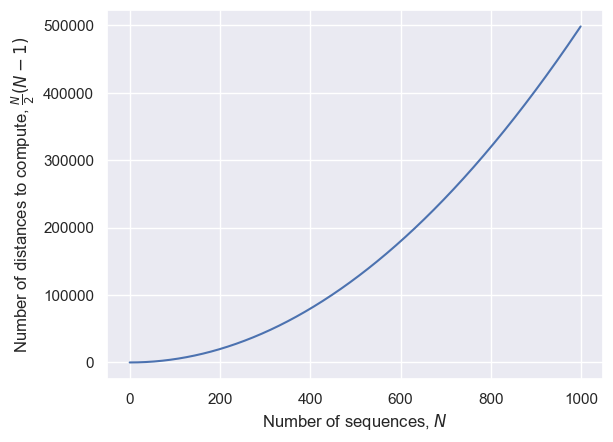

In [7]:
N = np.arange(1000)
ax = sns.lineplot(x=N, y=special.comb(N, 2))
ax.set(xlabel="Number of sequences, $N$", ylabel=r"Number of distances to compute, $\frac{N}{2}(N - 1)$")
plt.show()

With this in mind, let's get started!

In [8]:
target = "gene"
selected_genes = df[target].value_counts().iloc[:5].index
total_size = 1000
subset = (
    df.loc[df[target].isin(selected_genes)]
    .groupby(target)
    .apply(lambda e: e.iloc[: total_size // len(selected_genes)])
    .reset_index(drop=True)
)

The distance functions we want to consider are listed below.

In [9]:
METRICS = (
    setriq.CdrDist,
    setriq.Levenshtein,
    setriq.LongestCommonSubstring,
    setriq.OptimalStringAlignment,
    setriq.Jaro,
    setriq.JaroWinkler,
)

As an initial sanity check, we want to see whether the distance functions capture _any_ relevant variance for this task. Below, we plot the $t$-SNE of the sequences, when their dissimilarity defined by `CdrDist`. From it we can clearly see that there are some tight clusters forming for specific genes.

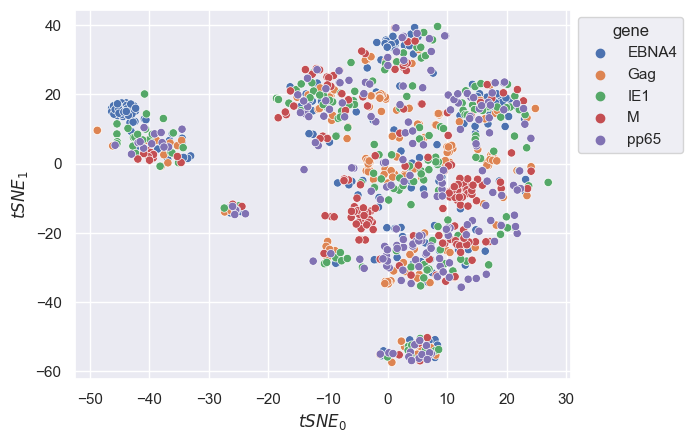

In [10]:
with warnings.catch_warnings():
    # sklearn.manifold.TSNE throws FutureWarnings about changes that will happen
    # we can safely ignore these here
    warnings.simplefilter("ignore", FutureWarning)
    ax = sns.scatterplot(
        data=pd.DataFrame(
            manifold.TSNE(metric="precomputed", random_state=42)
            .fit_transform(setriq.CdrDist(return_squareform=True)(subset["cdr3"])),
            columns=["t0", "t1"]
        ).assign(**{target: subset[target]}),
        x="t0",
        y="t1",
        hue=target,
    )

ax.set(xlabel="$tSNE_0$", ylabel="$tSNE_1$")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

As an initial benchmark, we can compute the mean [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) for each distance measure. Briefly, the silhoutte score $s_i$ for point $i$ is a measure of how similar it is to points of the same cluster, versus how dissimilar it is to points of other clusters:

$$
s_i = \frac{b_i - a_i}{\max\{a_i, b_i\}}
$$

where $a_i$ is the mean distance between point $i$ and the other points of the same cluster, and $b_i$ is the mean distance between point $i$ and the points of all other clusters. Hence, $s_i$ is in the range $[-1, 1]$, where more positive means "better".

In [11]:
sscores = []
for metr in METRICS:
    m = metr(return_squareform=True)
    sscores.append(
        (
            metr.__name__,
            metrics.silhouette_score(m(subset["cdr3"]), subset[target], metric="precomputed")
        )
    )

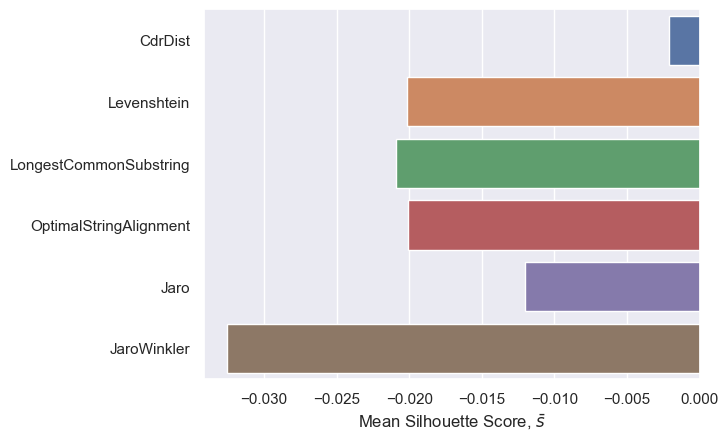

In [12]:
ax = sns.barplot(
    data=pd.DataFrame(sscores, columns=["metric", "silhouette_score"]),
    x="silhouette_score",
    y="metric"
)
ax.set(xlabel=r"Mean Silhouette Score, $\bar{s}$", ylabel="")
plt.show()

From this we can see that `CdrDist`, which was specifically designed for this use-case, performs the best in creating distinct clusters for functionally different TCRs. Note, however, that none of these perform particularly well here.